In [1]:
import Auto_BGC
import BGC
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import f1_score
from statsmodels.multivariate.manova import MANOVA

In [2]:
#Metrics for consideration
#Dunn Index -> similar to davie-bouldin

#Articles
#On the difficulty of generalized cluster metrics and solutions: https://gking.harvard.edu/files/gking/files/201018067_online.pcassini
#Proposes the method of the Hopkins statistic as a clustering metric: https://ieeexplore.ieee.org/document/1375706
#Proposes a "comprehensive" validity index for clustering: https://dl.acm.org/doi/10.5555/1497136.1497138

In [3]:
#Preparing the datasets
all_datasets=[]
cwd = os.getcwd()+"/datasets"

s1_x = pd.read_csv(cwd+"/s1.txt", delim_whitespace=True, header=None).to_numpy()
s1_y = pd.read_csv(cwd+"/s1-label.pa", delim_whitespace=True, header=None).to_numpy().flatten()
all_datasets.append((s1_x,s1_y))

s4_x = pd.read_csv(cwd+"/s4.txt", delim_whitespace=True, header=None).to_numpy()
s4_y = pd.read_csv(cwd+"/s4-label.pa", delim_whitespace=True, header=None).to_numpy().flatten()
all_datasets.append((s4_x,s4_y))

a1_x = pd.read_csv(cwd+"/a1.txt", delim_whitespace=True, header=None).to_numpy()
a1_y = pd.read_csv(cwd+"/a1-ga.pa", delim_whitespace=True, header=None).to_numpy().flatten()
all_datasets.append((a1_x,a1_y))

a2_x = pd.read_csv(cwd+"/a2.txt", delim_whitespace=True, header=None).to_numpy()
a2_y = pd.read_csv(cwd+"/a2-ga.pa", delim_whitespace=True, header=None).to_numpy().flatten()
all_datasets.append((a2_x,a2_y))

spiral_x = pd.read_csv(cwd+"/spiral.txt", delim_whitespace=True, header=None)
spiral_y = spiral_x[2].to_numpy().flatten()
spiral_x = spiral_x.drop(spiral_x.columns[2], axis=1).to_numpy()
all_datasets.append((spiral_x,spiral_y))

cassini = pd.read_csv('cassini.csv') 
cassini = cassini.drop(cassini.columns[0], axis = 1)
cassini_x = cassini.to_numpy()
cassini_y = cassini_x[:,-1]
cassini_y = cassini_y - 1
cassini_y=cassini_y.astype(int)
cassini_x = cassini_x[:,0:cassini_x.shape[1]-1]
all_datasets.append((cassini_x, cassini_y))

d_5 = pd.read_csv(cwd+"/D_5.csv")
d_5 = d_5.drop(d_5.columns[0], axis = 1)
d_5_x = d_5.to_numpy()
all_datasets.append((d_5_x,[]))

In [4]:
def plot_original(x, y):
    fig = plt.figure(figsize=(4, 4))
    gs = GridSpec(nrows=1, ncols=1)
    test_plot = fig.add_subplot(gs[0,0])
    test_plot.scatter(x[:,0], x[:,1], c=y, s=0.9)
    test_plot.set_title("Original Dataset")
    plt.tight_layout()
    fig.show()

<ipython-input-4-9e302c393184>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


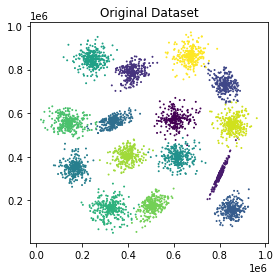

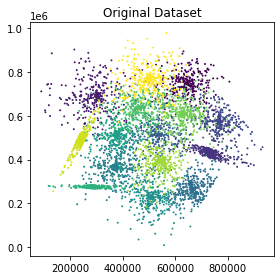

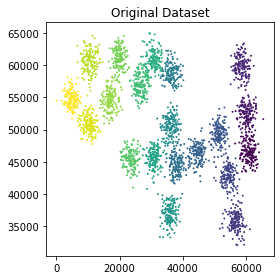

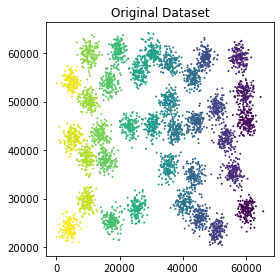

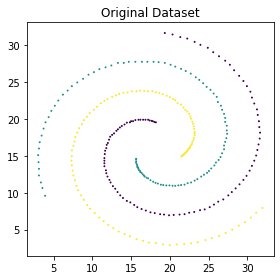

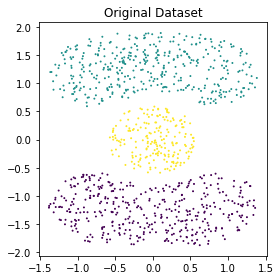

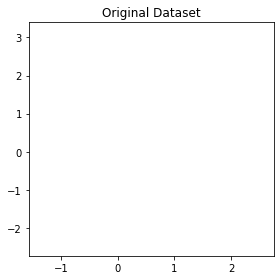

In [5]:
for data in all_datasets:
    x,y=data
    plot_original(x,y)

In [6]:
#future direction: if using constrained consensus, allow for the partition generation to be automated with a variable to define the distance from 
#the desired number of clusters
#The number of initial partitions chosen can greatly impact the outcome of a consensus -> possible improvement to the algorithm could be better contraint
dataset_partitions = []
dataset_centers = []
dataset_ranges = []

s_range=np.arange(2,25) #real=15
dataset_ranges.append(s_range)
a1_range=np.arange(2,30) #real=20
dataset_ranges.append(a1_range)
a2_range=np.arange(2,45) #real=35
dataset_ranges.append(a2_range)
spiral_range=np.arange(2,6) #real=3
dataset_ranges.append(spiral_range)
cassini_range=np.arange(2,10) #real=3
dataset_ranges.append(cassini_range)
d5_range=np.arange(2,9)
dataset_ranges.append(d5_range)

p1, c1 = Auto_BGC.generate_partitions(s_range, all_datasets[0][0], give_centers=True)
dataset_partitions.append(p1)
dataset_centers.append(c1)
p2, c2 = Auto_BGC.generate_partitions(s_range, all_datasets[1][0], give_centers=True)
dataset_partitions.append(p2)
dataset_centers.append(c2)
p3, c3 = Auto_BGC.generate_partitions(a1_range, all_datasets[2][0], give_centers=True)
dataset_partitions.append(p3)
dataset_centers.append(c3)
p4, c4 = Auto_BGC.generate_partitions(a2_range, all_datasets[3][0], give_centers=True)
dataset_partitions.append(p4)
dataset_centers.append(c4)
p5, c5 = Auto_BGC.generate_partitions(spiral_range, all_datasets[4][0], give_centers=True)
dataset_partitions.append(p5)
dataset_centers.append(c5)
p6, c6 = Auto_BGC.generate_partitions(d5_range, all_datasets[5][0], give_centers=True)
dataset_partitions.append(p6)
dataset_centers.append(c6)

In [7]:
def get_stats(x,y):
    try:
        manova = MANOVA(endog=x, exog=y)
        man_out=manova.mv_test().results
        man_f_res=man_out['x0']['stat']['F Value']['Hotelling-Lawley trace']
    except ValueError:
        man_f_res = 0

    measure = []

    if(len(set(y))>1):
        measure.append(silhouette_score(x, y))
        measure.append(calinski_harabasz_score(x, y))
        measure.append(davies_bouldin_score(x, y))
        measure.append(len(set(y)))
        measure.append(man_f_res)
        
    return measure

In [8]:
def multiple_consensus(partitions, data, centers, ranges, restrict=[], not_2d=[]):
    num = len(partitions)
    fig_newton = plt.figure(figsize=(18, 6*num))
    cringe = GridSpec(nrows=num, ncols=3)
    predictions = []
    stats = []
    
    for x in range(num):
        if(x not in restrict):
            data_stats = []
            data_pred = []
            print("Computing the best consensus...")
            if(len(data[x][1])==0):
                bruh, extra = Auto_BGC.theoretical_consensus(partitions[x], data[x][0], method=2, thresh_abs_mag=0.6, plot_hierarchy=False)
            else:
                bruh, extra = Auto_BGC.theoretical_consensus(partitions[x], data[x][0], method=2, thresh_abs_mag=0.6, plot_hierarchy=False, supervised=True, truth=data[x][1])
            bruh = BGC.output_to_array(bruh, data[x][0].shape[0])
            print(bruh)
            data_pred.append(bruh)
            data_stats.append(get_stats(data[x][0], bruh))
            print("Computing the best k-means...")
            best_k , k_stat= Auto_BGC.best_kmeans(data[x][0], ranges[x], centers[x])
            data_pred.append(best_k)
            data_stats.append(k_stat)
            stats.append(data_stats)
        
            if(x not in not_2d):
                cool_clust = fig_newton.add_subplot(cringe[x,0])
                cool_clust.scatter(data[x][0][:,0], data[x][0][:,1], c=bruh)
                string1="Consensus of Dataset "+str(x)+" (Unconstrained)"
                cool_clust.set_title(string1)
            
                cool_clust_2 = fig_newton.add_subplot(cringe[x,1])
                cool_clust_2.scatter(data[x][0][:,0], data[x][0][:,1], c=best_k)
                string2="Best K-means of Dataset " + str(x)
                cool_clust_2.set_title(string2)
        
                if(len(data[x])==2):
                    cool_clust_3 = fig_newton.add_subplot(cringe[x,2])
                    cool_clust_3.scatter(data[x][0][:,0], data[x][0][:,1], c=data[x][1])
                    string3="Truth Dataset "+str(x)
                    cool_clust_3.set_title(string2)
        
    return (predictions,stats)

In [10]:
predictions, stats = multiple_consensus(dataset_partitions, all_datasets, dataset_centers, dataset_ranges, restrict=[0,1,2,3,4], not_2d=[5])
#for x in stats:
    #print("Silhouette:",x[0][0],"Calinski:",x[0][1],"Bouldin:",x[0][2],"Clusters:",x[0][3],"MANOVA F-score:",x[0][4])
    #print("Silhouette:",x[1][0],"Calinski:",x[1][1],"Bouldin:",x[1][2],"Clusters:",x[1][3],"MANOVA F-score:",x[1][4])
print(stats)

Computing the best consensus...
Beginning Analysis of ideal threshold values...
Layer 1 -> Threshold: 0.35000 : Number of Clusters 7
Layer 2 -> Threshold: 0.02500 : Number of Clusters 3
Layer 3 -> Threshold: 0.02500 : Number of Clusters 2
Layer 4 -> Threshold: 0.45000 : Number of Clusters 4
Layer 5 -> Threshold: 0.10000 : Number of Clusters 1
Layer 6 -> Threshold: 0.02500 : Number of Clusters 1
Consensus Achieved
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

ValueError: y should be a 1d array, got an array of shape () instead.

<Figure size 1296x2592 with 0 Axes>